In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import tools
%matplotlib notebook

### komentarji:
    
    - omejitev števila točk (urejeno glede na "moč" ujemanja)
    - log napak projekcije
    - boljša triangulacija!
    - unikaten identifier vsake matrike ``[R|t]`` (da niso naslavljane po indeksu)

In [2]:
SCALE = 0.2
MATCH_RATIO = 0.85 # more -> LESS matches rejected
NFEV = 20000
MODE = 'ORB'

In [3]:
d_max = 1
alpha = 0.995

In [4]:
path = 'images/kip'
path_calib = 'kalibracija/redmi'
images = glob.glob(os.path.join(path, '*.JPG'))[1:-1]
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))

### main loop

In [5]:
scene = {}
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)
N = len(images)

--- BUNDLE ADJUSTMENT ---
parameters:	678 
cost before BA:	4790804590.58
optimization summary:
	cost 38807.55967
	nfev 20389.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	77615.12 



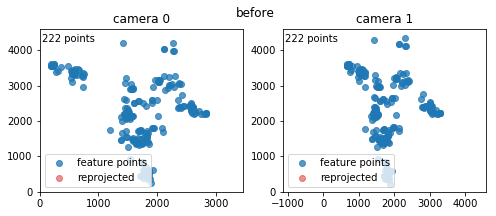

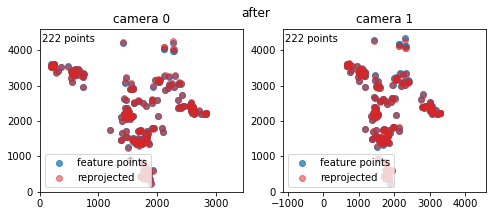

PnPRANSAC  107
--- BUNDLE ADJUSTMENT ---
parameters:	729 
cost before BA:	13274615831.69
optimization summary:
	cost 9463.14192
	nfev 20456.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	18926.28 



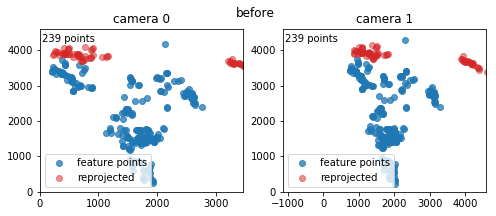

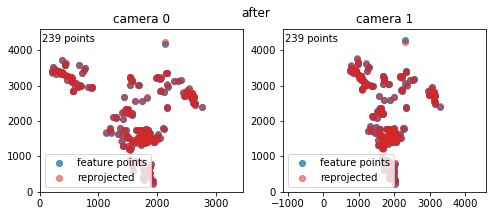

PnPRANSAC  114
--- BUNDLE ADJUSTMENT ---
parameters:	654 
cost before BA:	7815492715942.66
optimization summary:
	cost 184064147.07718
	nfev 20313.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	368128294.15 



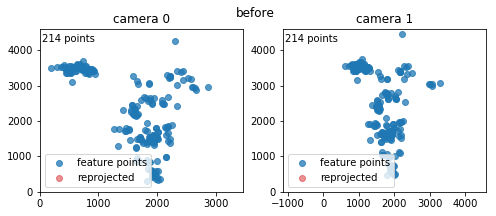

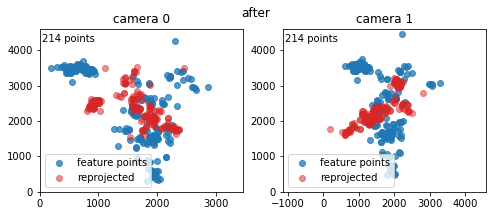

PnPRANSAC  84
--- BUNDLE ADJUSTMENT ---
parameters:	612 
cost before BA:	36495520060611.44
optimization summary:
	cost 23195162.33865
	nfev 20241.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	46390324.68 



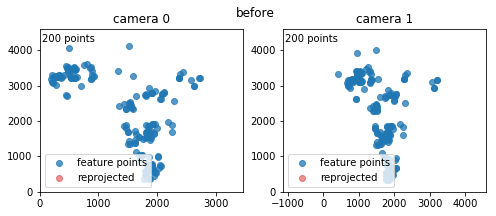

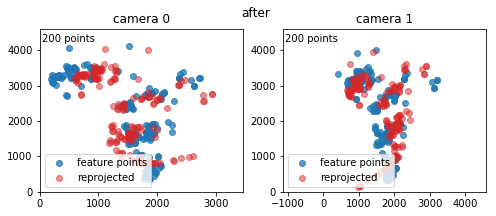

PnPRANSAC  87
--- BUNDLE ADJUSTMENT ---
parameters:	729 
cost before BA:	182102907966898.81
optimization summary:
	cost 50027653.00804
	nfev 20450.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	100055306.02 



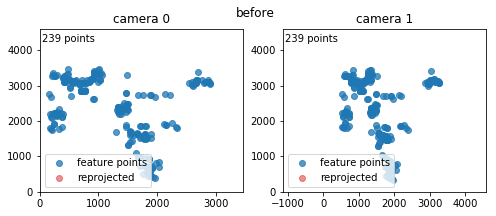

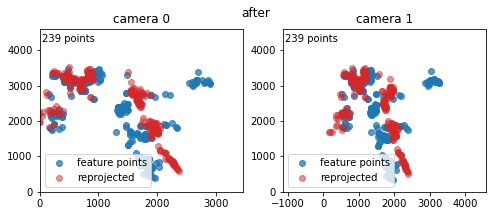

PnPRANSAC  83
--- BUNDLE ADJUSTMENT ---
parameters:	702 
cost before BA:	483351945194849.56
optimization summary:
	cost 14504883.65217
	nfev 20396.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	29009767.30 



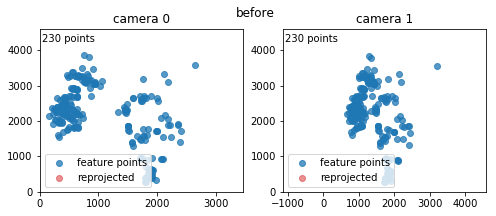

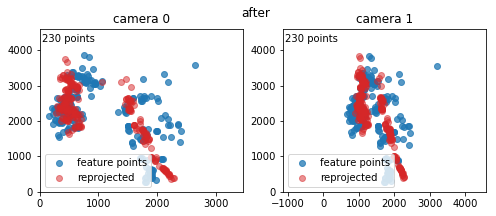

PnPRANSAC  58
--- BUNDLE ADJUSTMENT ---
parameters:	432 
cost before BA:	27447332986535.71
optimization summary:
	cost 198989.43126
	nfev 20363.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	397978.86 



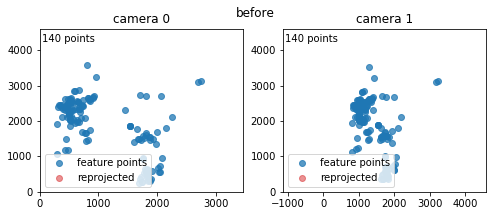

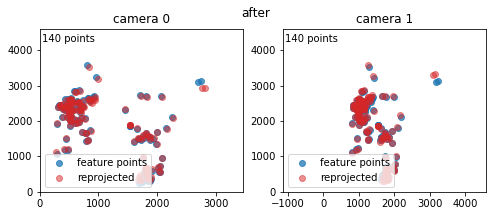

PnPRANSAC  57
--- BUNDLE ADJUSTMENT ---
parameters:	672 
cost before BA:	34547302207812.54
optimization summary:
	cost 1169398025595.79541
	nfev 20201.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	2338796051191.59 



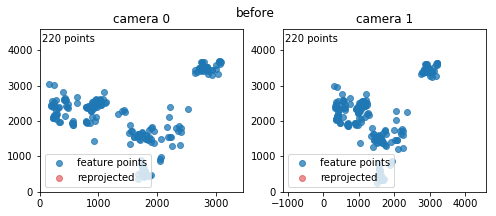

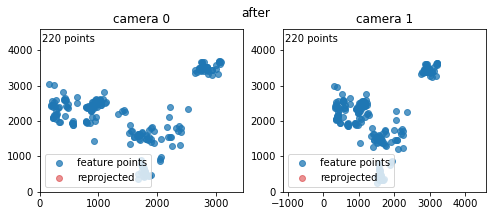

PnPRANSAC  56
--- BUNDLE ADJUSTMENT ---
parameters:	255 
cost before BA:	47311760942.77
optimization summary:
	cost 686323.60794
	nfev 20236.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	1372647.22 



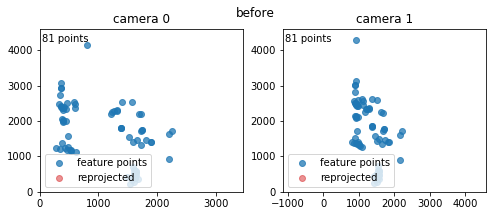

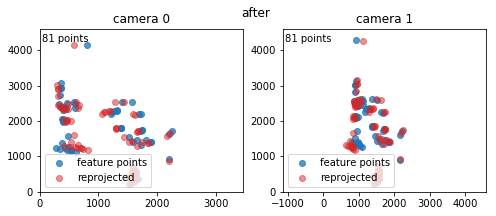

Too few (27) matches for PnPRANSAC, calculating Fundamental matrix.
--- BUNDLE ADJUSTMENT ---
parameters:	465 
cost before BA:	1841073382.93
optimization summary:
	cost 76096909.52423
	nfev 20052.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	152193819.05 



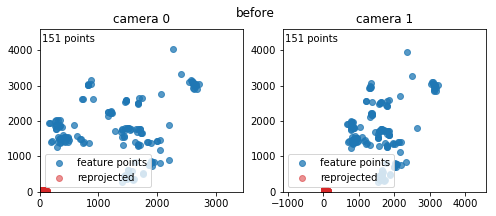

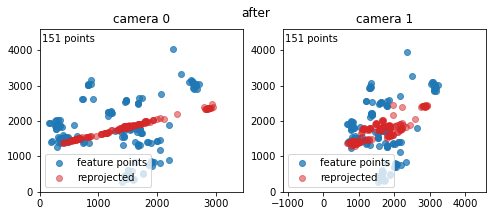

PnPRANSAC  70
--- BUNDLE ADJUSTMENT ---
parameters:	669 
cost before BA:	11744039139.25
optimization summary:
	cost 72620094.29201
	nfev 20114.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	145240188.58 



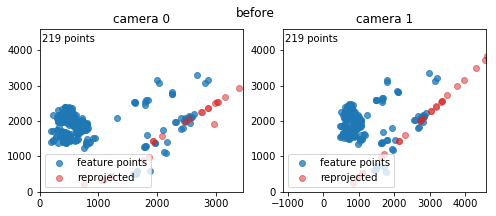

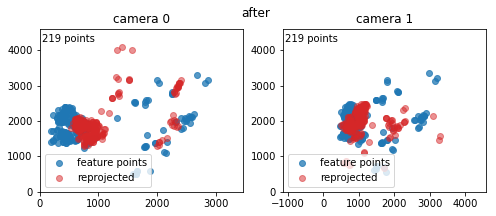

Too few (16) matches for PnPRANSAC, calculating Fundamental matrix.
--- BUNDLE ADJUSTMENT ---
parameters:	66 
cost before BA:	158050331.43
optimization summary:
	cost 566099.00368
	nfev 20040.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	1132198.01 



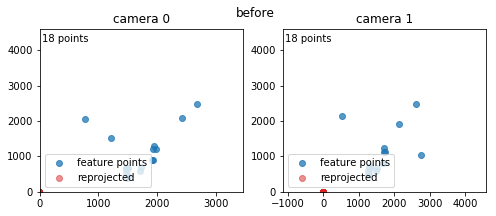

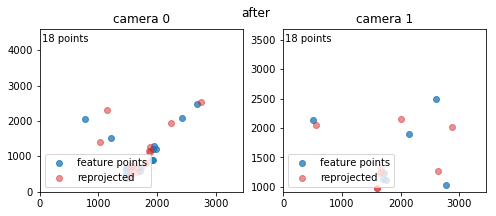

In [6]:
plot = False
%matplotlib inline

for i in tqdm_notebook(range(N - 1)):
    
    if i == 0:
        last_Rt = None
        im1 = tools.read_bw(images[i])
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices(im1, im2, K, last_Rt, d_max=d_max, alpha=alpha,
                                           scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)
    else:
        im1 = im2
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices_PnP(im1, im2, K, last_Rt, cloud, i, distCoeffs, 
                                            d_max=d_max, alpha=alpha, scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)

    last_Rt = Rt2
    P1 = K.dot(Rt1)
    P2 = K.dot(Rt2)
    
    points3D = []
    for x1, x2 in zip(p1, p2):
        X = tools.triangulate_lsq(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2)
        points3D.append(tools.Point3D(X, x1, x2, i, i+1))
    
    if i == 0:
        cloud = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, debug=True)
        cloud.bundle_adjustment(ftol=1e-12, max_nfev=NFEV, max_sd_dist=2, X_only=False)
    else:
        pair = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, frame_offset=i, debug=True)
        pair.bundle_adjustment(ftol=1e-12, max_nfev=NFEV, max_sd_dist=2, X_only=False)
        cloud.add_next_pair(pair)
        
    if plot:# and i % (N//2) == 0:
        print('---- slika {:d} ----\n'.format((i+1)))
        cloud.render()
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].imshow(im1, cmap='gray')
        ax[0].scatter(p1[:, 0], p1[:, 1])
        ax[1].imshow(im2, cmap='gray')
        ax[1].scatter(p2[:, 0], p2[:, 1])
        plt.show()

In [7]:
#X, Y, Z = cloud.render()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


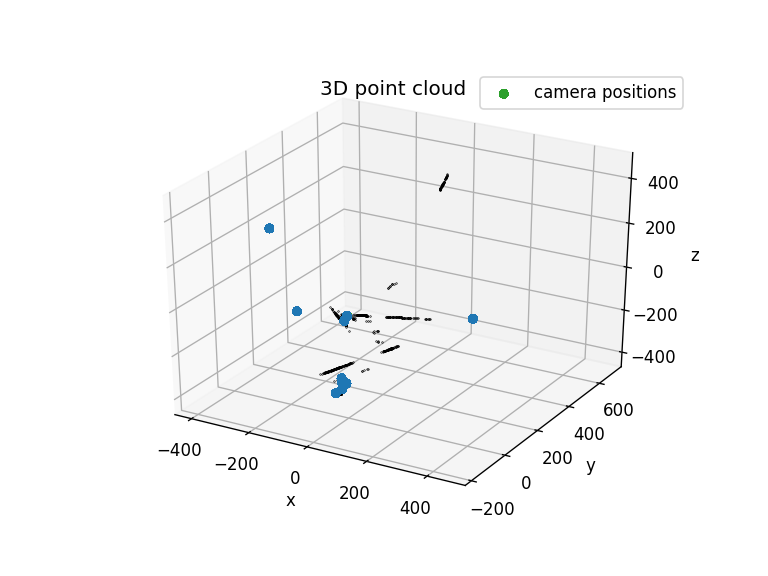

2006 identified points (2006 shown).


In [8]:
%matplotlib
X, Y, Z = cloud.render(cameras=True)

In [9]:
#cloud.bundle_adjustment(ftol=1e-1, max_nfev=2)
#X, Y, Z = cloud.render(cameras=True, openGL=True)

In [10]:
name = path.replace('/', '_').replace('\\', 'n')
cloud.pickle_save(name=name, path='results', mode='scene')

Saved scene to: results\scene_kip_09-08-13-49.pkl


In [11]:
#cloud.render(openGL=True, cameras=True)